# JOB-SHOP PROBLEM WITH GENETIC ALGORITHM 

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Read Dataset

In [2]:
def read_data(file):
    df = pd.read_excel(file, header=None)
    matrix = []

    # Iterate over rows to process job data
    for job in df.itertuples(index=False):
        # Convert the row into pairs of (machine, time)
        row_data = list(job)
        job_data = {}
        for i in range(0, len(row_data), 2):
            machine = int(row_data[i])
            time = int(row_data[i+1])
            job_data[machine] = time
        matrix.append(job_data)

    result_df = pd.DataFrame(matrix).fillna(0).astype(int)
    return result_df

In [3]:
data = read_data("JSSP-problems/la01.xlsx")
data

,1,0,4,3,2
0,21,53,95,55,34
1,71,21,16,52,26
2,42,12,98,39,31
3,77,55,79,77,66
4,19,83,37,34,64
5,54,92,79,62,43
6,87,93,77,69,87
7,41,60,83,24,38
8,49,44,25,17,98
9,75,96,77,79,43


## Plot Functions

In [4]:
def plot_evolution(minimum_fitness_per_generation):
    generations = list(range(len(minimum_fitness_per_generation)))
    plt.figure(figsize=(10, 6))
    plt.plot(generations, minimum_fitness_per_generation, marker='o', label='Minimum Makespan')
    plt.title('Evolution of Minimum Makespan Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Minimum Makespan (Fitness)')
    plt.grid()
    plt.legend()
    plt.show()


In [5]:
def plot_solution(chromosome, data):
    job_end_time = [0] * data.shape[0]  # End time for each job
    machine_end_time = [0] * data.shape[1]  # End time for each machine
    task_schedule = []  # To store the schedule for plotting
    num_machines = data.shape[1]
    num_jobs = data.shape[0]

    # Process the chromosome
    for job, machine in chromosome:
        start_time = max(job_end_time[job], machine_end_time[machine])
        end_time = start_time + data[machine][job]
        task_schedule.append((job, machine, start_time, end_time))  # Store the task details
        job_end_time[job] = end_time  # Update job end time
        machine_end_time[machine] = end_time  # Update machine end time

    fig, ax = plt.subplots(figsize=(10, 8))
    machine_colors = plt.cm.tab20.colors

    for job, machine, start_time, end_time in task_schedule:
        ax.barh(machine, end_time - start_time, left=start_time, color=machine_colors[job % 20])
 
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f"M{m}" for m in range(num_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title("Job-Shop Scheduling Solution")
    ax.invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Legend
    legend_patches = [
        mpatches.Patch(color=machine_colors[job % 20], label=f"Job {job}")
        for job in range(len(data))
    ]
    ax.legend(handles=legend_patches, title="Jobs", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


## Generate Initial Population

In [6]:
def generate_inital_population(data, population_size):
    jobs = data.shape[0]
    machines = data.shape[1]
    population = []
    for _ in range(population_size):
        chromosome = []
        for job in range(jobs):
            for machine in range(machines):
                chromosome.append((job, machine))
        random.shuffle(chromosome)
        population.append(chromosome)
    return population


## Fitness

In [7]:
def fitness(chromosome, data):
    job_end_time = [0] * data.shape[0]  # End time of each job
    machine_end_time = [0] * data.shape[1]  # End time of each machine
    
    for task in chromosome:
        job, machine = map(int, task)
        start_time = max(job_end_time[job], machine_end_time[machine]) # Start time of the task
        job_end_time[job] = start_time + data[machine][job] # Update end time of job
        machine_end_time[machine] = start_time + data[machine][job] # Update end time of machine
    
    return max(machine_end_time)  # Makespan

## Selection Functions

### Tournament Selection

In [8]:
def tournament_selection(population, fitness_values, tournament_size): # Tournament selection
    selected = set()
    
    while len(selected) < 2:  # Select 2 parents
        tournament = random.sample(list(enumerate(fitness_values)), tournament_size)
        winner = min(tournament, key=lambda x: x[1])[0] # Select the chromosome with the lowest fitness value
        selected.add(winner)

    selected = list(selected)
    parent1 = population[selected[0]]
    parent2 = population[selected[1]]

    # Ensure that parent1 and parent2 are not the same
    while parent1 == parent2:
        tournament = random.sample(list(enumerate(fitness_values)), tournament_size)
        winner = min(tournament, key=lambda x: x[1])[0]
        parent2 = population[winner]
        
    return parent1, parent2

### Roulette Selection

In [9]:
def roulette_selection(population, fitness_values, tournament_size=None): # Roulette selection
    selected = set()
    
    # Calculate the total fitness
    total_fitness = sum(1.0 / (f + 1e-6) for f in fitness_values)  # Avoid division by zero

    # Calculate probabilities for each chromosome
    probabilities = [(1.0 / (f + 1e-6)) / total_fitness for f in fitness_values]

    # Select two parents
    parent1 = random.choices(population, weights=probabilities, k=1)[0]
    parent2 = random.choices(population, weights=probabilities, k=1)[0]

    # Ensure parent1 and parent2 are different
    while parent1 == parent2:
        parent2 = random.choices(population, weights=probabilities, k=1)[0]

    return parent1, parent2

## Crossover Functions

### Uniform Crossover

In [10]:
def uniform_crossover(parent1, parent2, probability): # Uniform crossover
    size = len(parent1)
    child1, child2 = [], []

    # Uniform crossover
    for i in range(size):
        if random.random() < probability:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])

    # Repair duplicated genes in children
    def repair(child, parent):
        used_genes = set(child)
        missing_genes = [gene for gene in parent if gene not in used_genes]
        for i in range(size):
            if child.count(child[i]) > 1:  # Check if the gene is duplicated
                if missing_genes:
                    child[i] = missing_genes.pop(0)  # Substitute duplicated gene with a missing gene
        return child

    child1 = repair(child1, parent1)
    child2 = repair(child2, parent2)

    return child1, child2

### One-Point Crossover

In [11]:
def one_point_crossover(parent1, parent2, probability=None): # One-Point crossover
    size = len(parent1)
    crossover_point = random.randint(1, size - 1)  # Select crossover point

    # Perform one-point crossover
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]

    # Repair duplicated genes in children
    def repair(child, parent):
        used_genes = set(child)
        missing_genes = [gene for gene in parent if gene not in used_genes]
        for i in range(size):
            while child.count(child[i]) > 1:  # Check if the gene is duplicated
                if missing_genes:
                    child[i] = missing_genes.pop(0)  # Replace duplicated gene with a missing one
        return child

    # Repair duplicates in children
    child1 = repair(child1, parent1)
    child2 = repair(child2, parent2)

    return child1, child2

## Mutation Functions

### Independent Gene Mutation

In [12]:
def independent_gene_mutation(chromosome, mutation_probability): 
    size = len(chromosome)
    original_genes = set(chromosome)
    mutated_genes = set()
    new_chromosome = []

    for i in range(size):
        if random.random() < mutation_probability:
            job, machine = chromosome[i]
            mutated_gene = (machine, job)  # Swap job and machine
            mutated_genes.add(mutated_gene)
    
    for gene in mutated_genes:
        new_chromosome.append(gene)
        missing_genes = [gene for gene in original_genes if gene not in mutated_genes]
        new_chromosome.extend(missing_genes)
            
    return chromosome

### One Mutation per Chromosome

In [13]:
def one_mutation(chromosome, mutation_probability=None): 
    original_genes = set(chromosome)
    new_chromosome = []

    gene1, gene2 = random.sample(chromosome, 2)  # Select two genes to swap
    new_chromosome = chromosome.copy()
    index1 = new_chromosome.index(gene1)
    index2 = new_chromosome.index(gene2)
    new_chromosome[index1] = gene2
    new_chromosome[index2] = gene1
            
    return chromosome

## Elitism

In [14]:
def elitism(population, fitness_values):
    elite = min(enumerate(fitness_values), key=lambda x: x[1])[0]  # Select the chromosome with the lowest fitness value
    return population[elite]

## Genetic Algorithm

In [15]:
def gen_algorithm(data, params):
    population_size = params["population_size"]
    mutation_rate = params["mutation_rate"]
    crossover_rate = params["crossover_rate"]
    max_generations = params["max_generations"]
    tournament_size = params["tournament_size"]
    crossover_function = params["crossover_function"]
    mutation_function = params["mutation_function"]
    selection_function = params["selection_function"]

    min_makespan_generation = []
    population = generate_inital_population(data, population_size)
    fitness_values = [fitness(chromosome, data) for chromosome in population]
    for generation in range(max_generations):
        new_population = []
        for _ in range(population_size):
            # Selection
            parent1, parent2 = selection_function(population, fitness_values, tournament_size)
            # Crossover
            child1, child2 = crossover_function(parent1, parent2, crossover_rate)
            # Mutation
            child1 = mutation_function(child1, mutation_rate)
            child2 = mutation_function(child2, mutation_rate)
            # add children to new population
            new_population.append(child1)

        # select best chromosome from previous generation (elitism)
        new_population.append(elitism(population, fitness_values))
        population = new_population 
        # calculate fitness values for new population
        fitness_values = [fitness(chromosome, data) for chromosome in population]
        min_makespan = min(fitness_values)
        min_makespan_generation.append(min_makespan)
        
        # Check for stationary state
        if len(min_makespan_generation) >= 100:
            last_generations_fitness = min_makespan_generation[-100:]
            all_equal = all(x == last_generations_fitness[0] for x in last_generations_fitness)
            if all_equal:
                break
    # Select the chromosome with the lowest fitness value
    best_chromosome = min(enumerate(fitness_values), key=lambda x: x[1])[0]
    return population[best_chromosome], fitness_values[best_chromosome], min_makespan_generation
    

## Algoritm Parameters

In [16]:
jobs, machines = data.shape
t_size = jobs // 4
population_size = jobs * machines * 2
print(f"Population Size: {population_size} - Tournament Size: {t_size}")

params = {"population_size": population_size, 
          "mutation_rate": 0.1, 
          "crossover_rate": 0.9,
          "max_generations": 1000, 
          "tournament_size": t_size, 
          "crossover_function": uniform_crossover,
          "selection_function": tournament_selection,
          "mutation_function": independent_gene_mutation}

Population Size: 100 - Tournament Size: 2


In [17]:
best_solution, fitness, min_makespan_generation = gen_algorithm(data, params)
print("Best solution:", best_solution)
print("Fitness:", fitness)

Best solution: [(8, 4), (0, 1), (5, 0), (4, 1), (4, 3), (3, 4), (1, 3), (6, 2), (3, 1), (4, 4), (5, 4), (2, 0), (9, 0), (7, 2), (3, 2), (5, 2), (6, 1), (4, 0), (9, 3), (0, 4), (1, 4), (7, 3), (4, 2), (6, 4), (3, 0), (1, 2), (8, 3), (2, 3), (9, 1), (7, 1), (9, 2), (1, 0), (6, 0), (8, 1), (2, 4), (0, 3), (7, 0), (5, 3), (5, 1), (6, 3), (0, 2), (1, 1), (8, 2), (9, 4), (7, 4), (2, 2), (3, 3), (0, 0), (8, 0), (2, 1)]
Fitness: 666


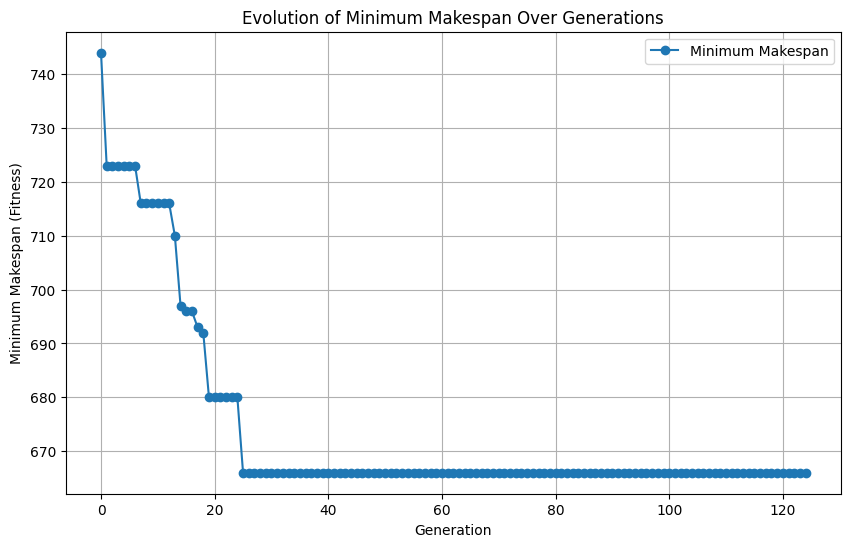

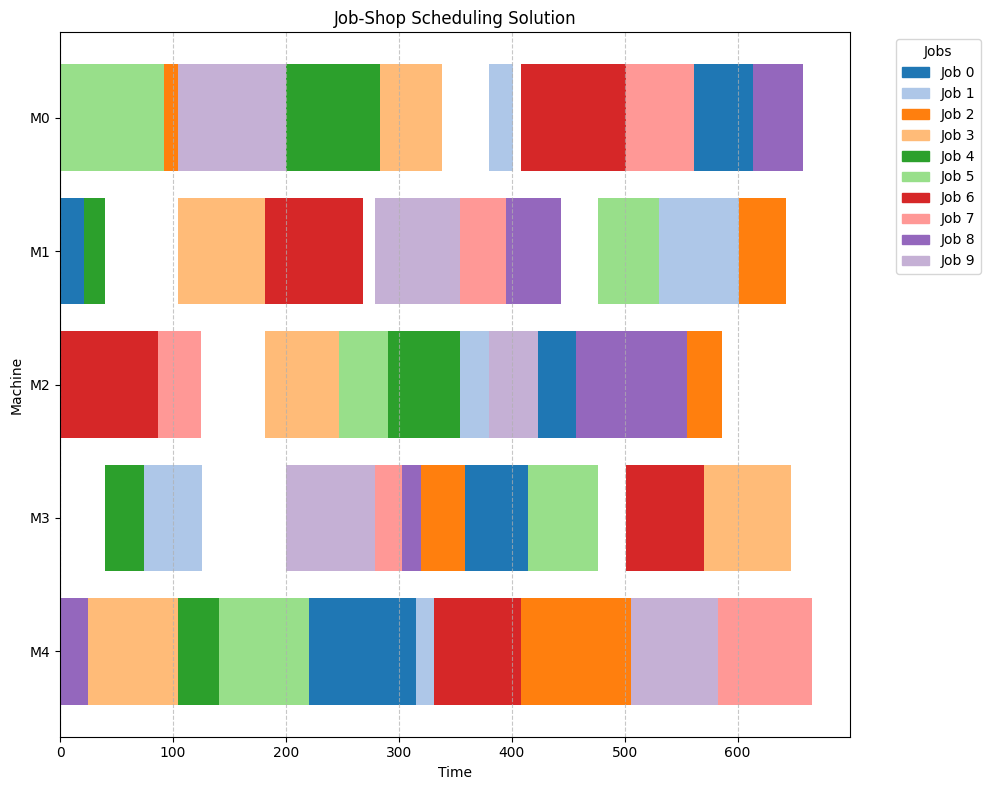

In [18]:
plot_evolution(min_makespan_generation)
plot_solution(best_solution, data)